In [1]:
# !pip install gensim
!pip install pyLDAvis
# !pip install wordcloud
# !pip install matplotlib
# !pip install numpy
# !pip install pandas
# !pip3 install spacy
# !pip3 install matplot
import gensim
import pandas as pd
import pyLDAvis
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re, numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 12.5 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.


In [2]:
import spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import  simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
# !pip install nltk
# !python -m pip install nltk.downloader stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['amp','from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Normal** **Tweets** 

In [4]:
# Import Dataset
from google.colab import drive 
drive.mount('/content/gdrive')
import pandas as pd 
df=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/tweets/tweets.csv',delimiter=',')
print(df.shape) 
df.head()

Mounted at /content/gdrive
(10001, 5)


_id         username  \
0  1621600585291014145    realJackEason   
1  1621600584360153088  ManojKu40226010   
2  1621600585358233600       TansyWatts   
3  1621600585391783943    Green_Man1984   
4  1621600586020933632   bruis3pristin3   

                                                text    qScore    nScore  
0  @pansexualflower Criterion certainly have US r...  0.613271  2.934114  
1  🇨🇳 🇺🇸 #China\n#Chinese #Foreign #Ministry said...  0.446642 -2.994406  
2  “As they began to understand the children’s op...  0.609156  1.772004  
3  Excess Deaths Skyrocket Again In England And W...  0.608929 -1.639187  
4  @altgirlalterego scotland, seychelles, syria, ...  0.608089 -0.254614

In [5]:
df['text'].apply(len).describe()

count    10001.00000
mean       151.90081
std         83.49657
min         18.00000
25%         84.00000
50%        132.00000
75%        215.00000
max        926.00000
Name: text, dtype: float64

In [6]:
# get the number of items
num_items = len(df)

# get the length of each tweet
tweet_lengths = df['text'].apply(len)

# get the minimum, maximum, and average length of tweets
min_length = tweet_lengths.min()
max_length = tweet_lengths.max()
avg_length = tweet_lengths.mean()


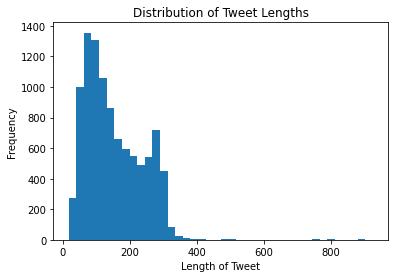

Number of tweets: 10001
Minimum tweet length: 18
Maximum tweet length: 926
Average tweet length: 151.90


In [7]:
# plot a histogram of tweet lengths
plt.hist(tweet_lengths, bins=40)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length of Tweet')
plt.ylabel('Frequency')
plt.show()

# print the statistics
print(f'Number of tweets: {num_items}')
print(f'Minimum tweet length: {min_length}')
print(f'Maximum tweet length: {max_length}')
print(f'Average tweet length: {avg_length:.2f}')

Text Preprocessing

In [8]:
# Removing tweets with low nscore and qscore to reduce spam
df=df[(df['nScore']>=0)&(df['qScore']>=0.5)]
df.shape

(7377, 5)

In [9]:
# Removing extra characters etc
def sent_to_words(sentences):
    for sent in sentences:
        sent = sent.lower()
        sent = re.sub(r'\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub(r'\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = re.sub(r'https?://\S+|www\.\S+','',sent) # remove https
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['criterion', 'certainly', 'have', 'us', 'rights', 'to', 'the', 'restoration', 'but', 'very', 'unlikely', 'they', 'have', 'any', 'claim', 'to', 'uk', 'uhd', 'rights', 'alone', 'this', 'seems', 'more', 'like', 'cost', 'analysis', 'decision', 'by', 'the', 'bfi', 'or', 'else', 'they', 'determined', 'the', 'new', 'restoration', 'doesnt', 'merit', 'for', 'home', 'release', 'which', 'would', 'be', 'odd']]


In [10]:
#Lemmatisation in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.

import en_core_web_sm
nlp = en_core_web_sm.load()

#!python3 -m spacy download en_core_web_md 
# !python3 -m spacy download en  # run in terminal once

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
   
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)  
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
   # nlp = spacy.load('en', disable=['parser', 'ner'])
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out



In [11]:
data_ready = process_words(data_words)  # processed Text Data!
data_ready[0]

/usr/local/lib/python3.9/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['criterion',
 'certainly',
 'restoration',
 'unlikely',
 'claim',
 'alone',
 'cost',
 'analysis',
 'decision',
 'bfi',
 'else',
 'determine',
 'new',
 'restoration',
 'merit',
 'home',
 'release',
 'odd']

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

Model And Evaluation 

In [ ]:
# Build LDA model
model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                          id2word=id2word,
                                          num_topics=5,
                                          random_state=5000,
      #                                   update_every=1,
      #                                   chunksize=70,
                                          passes=10,
                                          alpha='auto',
                                          per_word_topics=True)

# save model to disk (no need to use pickle module)
model.save('lda.model')

In [113]:
# Print Topic words
for i, topic in model.print_topics():
    print(f'\nTopic number: {i} \n Words: {topic} \n')


Topic number: 0 
 Words: 0.008*"year" + 0.006*"conservative" + 0.006*"new_york" + 0.005*"new" + 0.004*"weekend" + 0.004*"last" + 0.004*"offer" + 0.004*"first" + 0.004*"stop" + 0.004*"support" 


Topic number: 1 
 Words: 0.008*"conservative" + 0.007*"time" + 0.007*"labour" + 0.006*"government" + 0.006*"money" + 0.006*"worker" + 0.005*"work" + 0.005*"show" + 0.005*"sign" + 0.005*"start" 


Topic number: 2 
 Words: 0.016*"man" + 0.011*"people" + 0.009*"woman" + 0.005*"serve" + 0.005*"rest" + 0.005*"check" + 0.005*"much" + 0.005*"produce" + 0.004*"wait" + 0.004*"lab" 


Topic number: 3 
 Words: 0.005*"brexit" + 0.004*"lose" + 0.003*"look" + 0.003*"find" + 0.003*"maybe" + 0.003*"tory" + 0.003*"back" + 0.003*"call" + 0.003*"give" + 0.003*"lead" 


Topic number: 4 
 Words: 0.009*"day" + 0.008*"look" + 0.008*"well" + 0.008*"work" + 0.007*"new" + 0.007*"time" + 0.007*"great" + 0.006*"still" + 0.006*"people" + 0.006*"play" 



/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


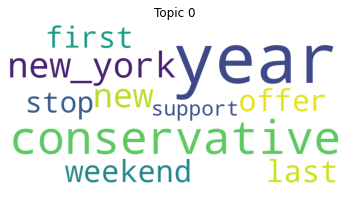

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


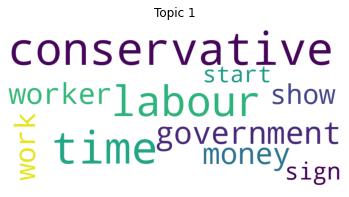

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


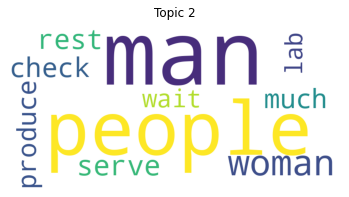

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


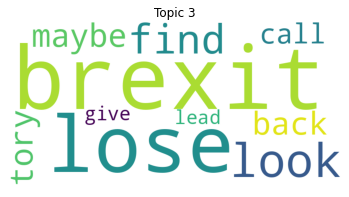

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


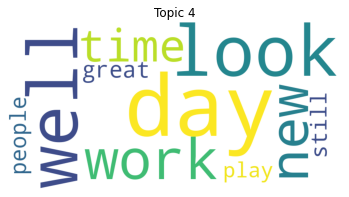

In [16]:
# Create wordcloud from topics
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def visualize_topics(model):
    topics = model.show_topics(num_topics=-1, formatted=False)
    for i, topic in topics:
        words = dict(topic)
        wordcloud = WordCloud(width=800, height=400, background_color='white')
        wordcloud.generate_from_frequencies(words)
        plt.figure()
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.title('Topic ' + str(i))
        plt.show()
        print(" ")

visualize_topics(model)

In [17]:
top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / model.num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -8.7496.


In [18]:
from gensim.models.coherencemodel import CoherenceModel
# Calculate model Coherence
coherence_model = CoherenceModel(model=model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print("Coherence score of the model is:", coherence_score)

Coherence score of the model is: 0.33401895002213233


In [ ]:
# Calculate log perplexity of model
perplexity = model.log_perplexity(corpus)
print("Perplexity of the model is:", perplexity)

In [20]:
print("Perplexity of the model is:", perplexity)

Perplexity of the model is: -8.704690908327237


In [21]:
#Creating Topic Distance Visualization 
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(model, corpus, id2word)
p

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.029509  0.165189       1        1  33.280332
1      0.102045 -0.100085       2        1  19.006505
0      0.007958  0.102921       3        1  18.496815
2     -0.200304 -0.107461       4        1  15.997504
3      0.119810 -0.060564       5        1  13.218843, topic_info=       Term        Freq       Total Category  logprob  loglift
311     man  164.000000  164.000000  Default  30.0000  30.0000
587   woman   90.000000   90.000000  Default  29.0000  29.0000
126  worker   61.000000   61.000000  Default  28.0000  28.0000
33      day  222.000000  222.000000  Default  27.0000  27.0000
493   money   74.000000   74.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
240   thing   16.957382  111.417619   Topic5  -6.0881   0.1409
560    well   17.684478  215.205491   Topic5  -6.0461  -0.4754
605    last   14.772726  108.794109   Topic5  -6.2260   0.0269
268  people   14.893172  287.782428   Topic5  -6.2179  -0.9378
335  labour   14.764955  210.370843   Topic5  -6.2265  -0.6331

[342 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2503      2  0.925588   absolute
397       2  0.952090     actual
2583      3  0.966285     affect
662       1  0.947263  afternoon
718       1  0.953084      ahead
...     ...       ...        ...
138       1  0.405167       year
138       2  0.054352       year
138       3  0.429872       year
138       4  0.039528       year
138       5  0.074116       year

[582 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 3, 4])

# **Grouped Tweets**

In [13]:
# Import Dataset
gdf=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/tweets/groupedTweets.csv',delimiter=',')
print(gdf.shape) 
gdf.head()

(9968, 6)


group              tweetID        username  \
0      0  1621600585291014145   realJackEason   
1      0  1621600597127331842          battez   
2      0  1621600609030782981    Reno_station   
3      0  1621600638256693252     pedrinho_uk   
4      0  1621600792812609541  ClimateSchmidt   

                                                text    qScore    nScore  
0  @pansexualflower Criterion certainly have US r...  0.613271  2.934114  
1  @StratAnalytica @EconguyRosie yeah I'm in UK j...  0.603617  1.712620  
2  @NappaBald66 Dry clean eraser should do the tr...  0.669598  3.165340  
3  @alanvibe @DrHoenderkamp @haringeycouncil @mik...  0.543737  3.485828  
4  @PGDynes Climate change is a real problem, but...  0.609599  1.870719

In [14]:
# compute some basic statistics on the text column
num_groups = len(gdf['group'].unique())
num_tweets = len(gdf)
num_chars = gdf['text'].apply(len)
num_words = gdf['text'].apply(lambda x: len(x.split()))

# compute additional statistics
max_words = num_words.max()
min_words = num_words.min()
mean_words = num_words.mean()
min_chars = num_chars.min()
max_chars = num_chars.max()
mean_chars = num_chars.mean()

# print the results
print(f"Number of groups: {num_groups}")
print(f"Number of tweets: {num_tweets}")
print(f"Maximum number of words in a group: {max_words}")
print(f"Minimum number of words in a group: {min_words}")
print(f"Mean number of words per group: {mean_words}")
print(f"Minimum length in characters: {min_chars}")
print(f"Maximum length in characters: {max_chars}")
print(f"Average length in characters: {mean_chars}")

Number of groups: 471
Number of tweets: 9968
Maximum number of words in a group: 100
Minimum number of words in a group: 4
Mean number of words per group: 23.441914125200643
Minimum length in characters: 18
Maximum length in characters: 926
Average length in characters: 151.93158105939006


In [15]:
gdf['text'].apply(len).describe()

count    9968.000000
mean      151.931581
std        83.507999
min        18.000000
25%        84.000000
50%       132.000000
75%       216.000000
max       926.000000
Name: text, dtype: float64

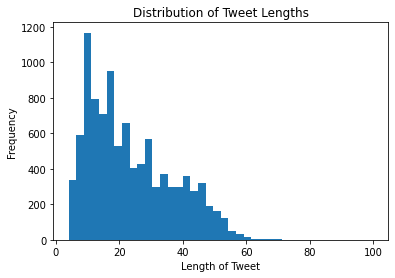

Number of tweets: 471
Minimum tweet length: 4
Maximum tweet length: 100
Average tweet length: 23.44


In [16]:
# get the number of items
num_items = num_groups

# get the length of each tweet
tweet_lengths = num_words

# get the minimum, maximum, and average length of tweets
min_length = tweet_lengths.min()
max_length = tweet_lengths.max()
avg_length = tweet_lengths.mean()

# plot a histogram of tweet lengths
plt.hist(tweet_lengths, bins=40)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length of Tweet')
plt.ylabel('Frequency')
plt.show()

# print the statistics
print(f'Number of tweets: {num_items}')
print(f'Minimum tweet length: {min_length}')
print(f'Maximum tweet length: {max_length}')
print(f'Average tweet length: {avg_length:.2f}')

Text Preprocessing

In [17]:
# Remove tweets with low nScore and qScpre 
gdf=gdf[(gdf['nScore']>=0)&(gdf['qScore']>=0.5)]
# Group tweets and concatenate them
gdata = gdf.groupby('group')['text']
gdata = gdata.apply(lambda str: "".join(str))
gdata.head()

group
0    @pansexualflower Criterion certainly have US r...
1    19' | 🐻 05-00🦈\n\nIt's another knock on from B...
2    “As they began to understand the children’s op...
3    Chelsea vs Fulham - Live Stream Premier League...
4    @Nigel_Farage Instead of getting unskilled/sem...
Name: text, dtype: object

In [18]:
# Removing Stopwords
gdata_words = list(sent_to_words(gdata))
print(gdata_words[:1])

[['criterion', 'certainly', 'have', 'us', 'rights', 'to', 'the', 'restoration', 'but', 'very', 'unlikely', 'they', 'have', 'any', 'claim', 'to', 'uk', 'uhd', 'rights', 'alone', 'this', 'seems', 'more', 'like', 'cost', 'analysis', 'decision', 'by', 'the', 'bfi', 'or', 'else', 'they', 'determined', 'the', 'new', 'restoration', 'doesnt', 'merit', 'for', 'home', 'release', 'which', 'would', 'be', 'yeah', 'im', 'in', 'uk', 'just', 'realised', 'this', 'context', 'and', 'it', 'all', 'seems', 'bit', 'sus', 'now', 'maybe', 'an', 'accounting', 'fudge', 'from', 'prev', 'month', 'to', 'create', 'this', 'month', 'hopefully', 'someone', 'qualified', 'will', 'look', 'into', 'dry', 'clean', 'eraser', 'should', 'do', 'the', 'trick', 'as', 'doesnt', 'look', 'to', 'bad', 'crumbly', 'for', 'heavier', 'stains', 'jean', 'bleed', 'etc', 'in', 'my', 'area', 'emergency', 'services', 'amp', 'thames', 'water', 'had', 'problems', 'accessing', 'roads', 'because', 'or', 'roadblock', 'ltn', 'seems', 'to', 'also', 'b

In [19]:
# Tokenize data
gdata_ready = process_words(gdata_words)  # processed Text Data!

/usr/local/lib/python3.9/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [20]:
# Create Dictionary
gid2word = corpora.Dictionary(gdata_ready)

# Create Corpus: Term Document Frequency
gcorpus = [gid2word.doc2bow(text) for text in gdata_ready]

Model and Evaluation

In [ ]:
# Build LDA model
gmodel = gensim.models.ldamodel.LdaModel(corpus=gcorpus,
                                          id2word=gid2word,
                                          num_topics=7,
                                          random_state=5000,
      #                                   update_every=1,
      #                                   chunksize=70,
                                          passes=10,
                                          alpha='auto',
                                          per_word_topics=True)

# save model to disk (no need to use pickle module)
gmodel.save('lda.model')

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


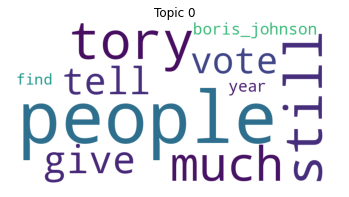

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


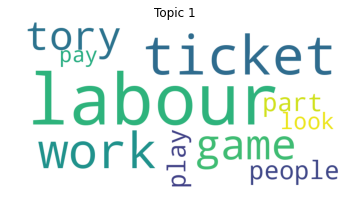

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


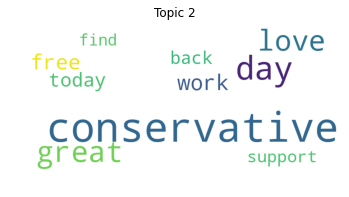

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


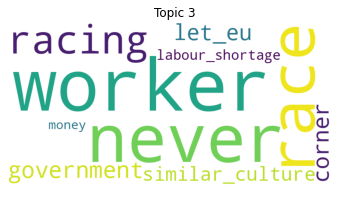

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


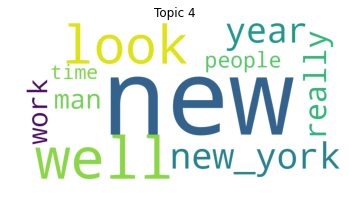

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


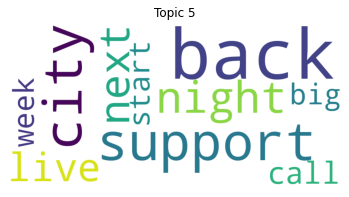

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


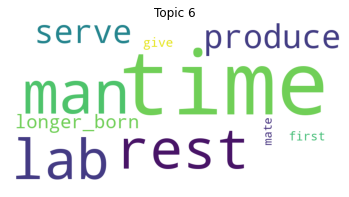

In [31]:
visualize_topics(gmodel)

In [32]:
gtop_topics = gmodel.top_topics(gcorpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_gtopic_coherence = sum([t[1] for t in gtop_topics]) / gmodel.num_topics
print('Average topic coherence: %.4f.' % avg_gtopic_coherence)

Average topic coherence: -2.0371.


In [ ]:
gperplexity = gmodel.log_perplexity(gcorpus)
print("Perplexity of the model is:", gperplexity)


In [34]:
print("Perplexity of the model is:", gperplexity)

Perplexity of the model is: -8.498722271980608


In [35]:
gcoherence_model = CoherenceModel(model=gmodel, texts=gdata_ready, dictionary=gid2word, coherence='c_v')
gcoherence_score = gcoherence_model.get_coherence()
print("Coherence score of the model is:", gcoherence_score)

Coherence score of the model is: 0.29554127170590616


In [36]:
pyLDAvis.enable_notebook()
pg = pyLDAvis.gensim.prepare(gmodel, gcorpus, gid2word)
pg

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.043043 -0.008954       1        1  27.590754
0      0.039436 -0.020459       2        1  21.573909
1      0.038050 -0.034862       3        1  15.225349
2      0.039638 -0.006393       4        1  11.771184
5      0.007945 -0.008900       5        1   8.903190
3     -0.031898  0.131151       6        1   8.036972
6     -0.136214 -0.051583       7        1   6.898643, topic_info=              Term        Freq       Total Category  logprob  loglift
1291          time  221.000000  221.000000  Default  30.0000  30.0000
1456  conservative  196.000000  196.000000  Default  29.0000  29.0000
458         labour  191.000000  191.000000  Default  28.0000  28.0000
3954      new_york  105.000000  105.000000  Default  27.0000  27.0000
1352        worker   76.000000   76.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
223           work    7.782429  208.169958   Topic7  -6.1705  -0.6126
893           full    5.822725   51.286288   Topic7  -6.4606   0.4982
56             day    7.039079  195.830273   Topic7  -6.2709  -0.6519
1082        people    7.041110  291.245351   Topic7  -6.2706  -1.0486
337           call    6.201503  106.686476   Topic7  -6.3976  -0.1713

[556 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
8421      3  0.187892  acquisition
8421      6  0.751569  acquisition
299       1  0.323636     actually
299       2  0.209412     actually
299       3  0.076150     actually
...     ...       ...          ...
1357      1  0.130916         zone
1357      3  0.130916         zone
1357      4  0.130916         zone
1357      5  0.130916         zone
1357      7  0.523662         zone

[1478 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 3, 6, 4, 7])

# Model Optimisation

In [21]:
def compute_metric_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    perplexity_values=[]
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                          id2word=id2word,
                                          num_topics=num_topics,
                                          random_state=5000,
      #                                   update_every=1,
      #                                   chunksize=70,
                                          passes=20,
                                          alpha='auto',
                                          per_word_topics=True,
                                          eta='symmetric')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(model.log_perplexity(corpus))

    return model_list, coherence_values,perplexity_values

Ungrouped Tweets

In [22]:
#Calculate coherence values for ungrouped tweets
model_list, coherence_values,perplexity_values = compute_metric_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit=40, step=6)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

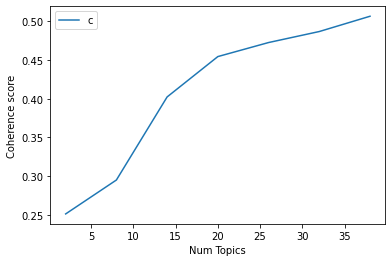

In [155]:
# Show graph for coherence values for different no of topics
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

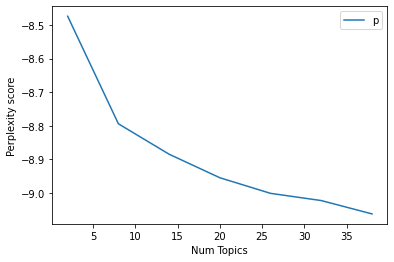

In [157]:
# Show graph for perplexity values for different number of topics
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [24]:
# Print the coherence scores
limit=40; start=2; step=6;
x = range(start, limit, step)
for m, cv ,pv in zip(x, coherence_values, perplexity_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4), " and perplexity ", round(pv,4))

Num Topics = 2  has Coherence Value of 0.2515  and perplexity  -8.4739
Num Topics = 8  has Coherence Value of 0.2952  and perplexity  -8.7943
Num Topics = 14  has Coherence Value of 0.4023  and perplexity  -8.8849
Num Topics = 20  has Coherence Value of 0.4543  and perplexity  -8.955
Num Topics = 26  has Coherence Value of 0.4724  and perplexity  -9.0015
Num Topics = 32  has Coherence Value of 0.4866  and perplexity  -9.023
Num Topics = 38  has Coherence Value of 0.5063  and perplexity  -9.0627


Grouped Tweets

In [25]:
# Calculating the same for grouped tweets
gmodel_list, gcoherence_values, gperplexity_values = compute_metric_values(dictionary=gid2word, corpus=gcorpus, texts=gdata_ready, start=2, limit=40, step=6)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

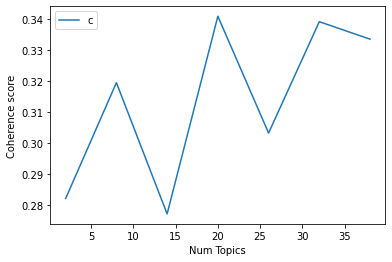

In [159]:
# Show graph for coherence values for different number of topics
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, gcoherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

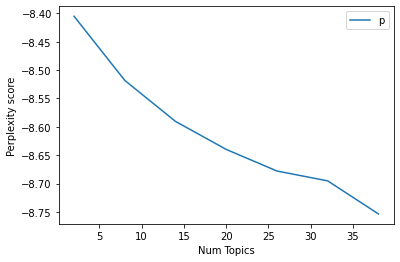

In [161]:
# Show graph for perplexity values for different number of topics
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, gperplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [26]:
# Print the coherence scores
for m, cv, pv in zip(x, gcoherence_values,gperplexity_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4)," and perplexity of", round(pv,4))

Num Topics = 2  has Coherence Value of 0.2822  and perplexity of -8.4052
Num Topics = 8  has Coherence Value of 0.3194  and perplexity of -8.5182
Num Topics = 14  has Coherence Value of 0.2772  and perplexity of -8.5904
Num Topics = 20  has Coherence Value of 0.3408  and perplexity of -8.6397
Num Topics = 26  has Coherence Value of 0.3032  and perplexity of -8.6778
Num Topics = 32  has Coherence Value of 0.339  and perplexity of -8.6951
Num Topics = 38  has Coherence Value of 0.3334  and perplexity of -8.7533


# Optimized Model And Evaluation

Ungrouped Tweets

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

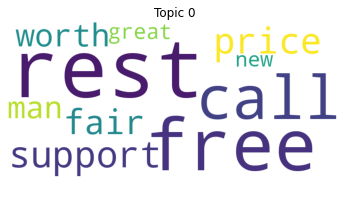

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


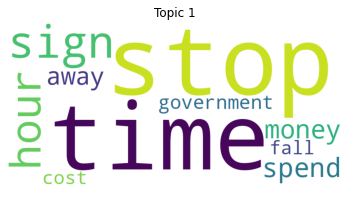

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


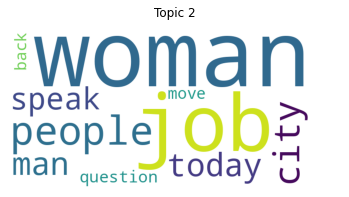

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


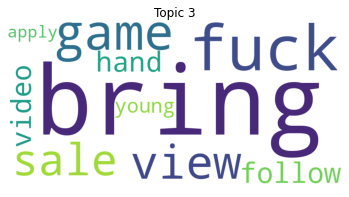

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


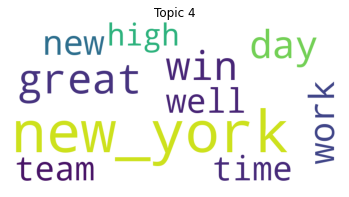

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


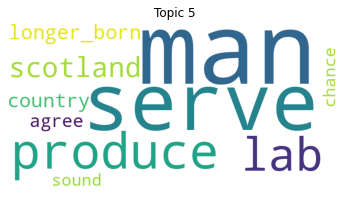

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


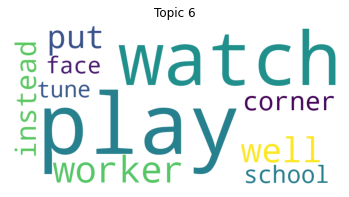

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


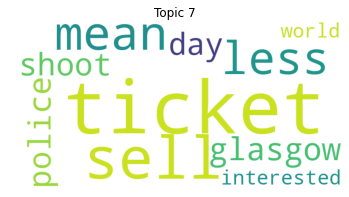

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


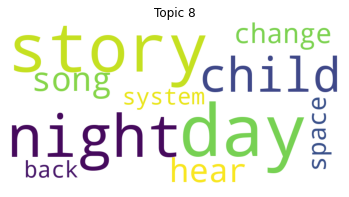

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


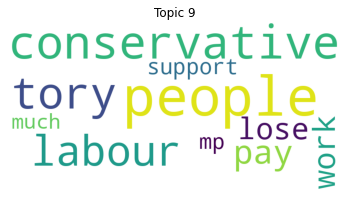

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


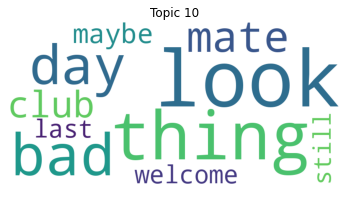

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


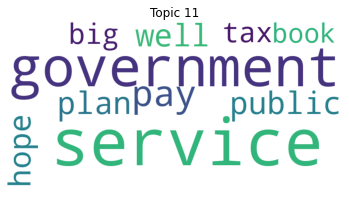

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


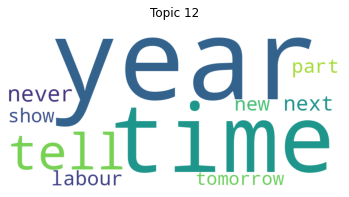

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


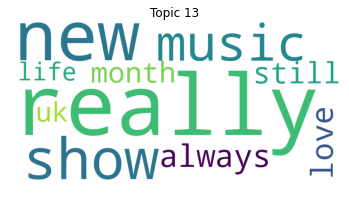

In [196]:
# Single Tweeets Optimal n
# Build LDA model
omodel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                          id2word=id2word,
                                          num_topics=14,
                                          random_state=5000,
      #                                   update_every=1,
      #                                   chunksize=70,
                                          passes=20,
                                          alpha='auto',
                                          per_word_topics=True,
                                         eta='symmetric')

visualize_topics(omodel)

In [ ]:
ocoherence_model = CoherenceModel(model=omodel, texts=data_ready, dictionary=id2word, coherence='c_v')
ocoherence_score = ocoherence_model.get_coherence()
operplexity = omodel.log_perplexity(corpus)

In [198]:
print("Coherence score of the model is:", ocoherence_score)
print("Perplexity of the model is:", operplexity)

Coherence score of the model is: 0.4022647188374178
Perplexity of the model is: -8.884903734485912


In [199]:
pyLDAvis.enable_notebook()
pg = pyLDAvis.gensim.prepare(omodel, corpus, id2word)
pg

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.212003  0.074862       1        1  10.757759
12    -0.172677 -0.093599       2        1  10.663791
4     -0.041839 -0.028145       3        1   8.159133
10     0.043081 -0.049988       4        1   7.527150
11    -0.051752 -0.102875       5        1   7.379938
1     -0.128695  0.044139       6        1   7.279202
2      0.038407  0.181725       7        1   6.769549
7      0.047507  0.038400       8        1   6.478972
5      0.076681  0.105810       9        1   6.322115
13     0.039336 -0.114135      10        1   6.247434
8      0.121100 -0.014211      11        1   5.964205
6      0.102020 -0.165821      12        1   5.911841
3      0.091729  0.031774      13        1   5.318848
0      0.047106  0.092064      14        1   5.220062, topic_info=              Term        Freq       Total Category  logprob  loglift
268         people  297.000000  297.000000  Default  30.0000  30.0000
261   conservative  230.000000  230.000000  Default  29.0000  29.0000
233           tory  180.000000  180.000000  Default  28.0000  28.0000
335         labour  213.000000  213.000000  Default  27.0000  27.0000
413       new_york  129.000000  129.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
12             new   18.749188  217.147766  Topic14  -5.0585   0.5032
138           year   18.431206  208.026694  Topic14  -5.0756   0.5290
145        account   11.319859   25.483861  Topic14  -5.5631   2.1412
366          place   11.811543   58.735655  Topic14  -5.5206   1.3487
1185         world   11.727175   70.257211  Topic14  -5.5278   1.1624

[868 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
6329     10  0.871068     ability
108       1  0.821037  absolutely
108      11  0.157892  absolutely
3656      8  0.948791    academic
145       5  0.078481     account
...     ...       ...         ...
1131     11  0.102581         yet
1131     13  0.123097         yet
794       5  0.039144       young
794      12  0.156575       young
794      13  0.782876       young

[1686 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 13, 5, 11, 12, 2, 3, 8, 6, 14, 9, 7, 4, 1])

Grouped Tweets

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

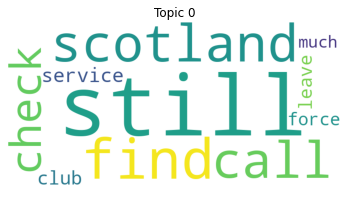

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


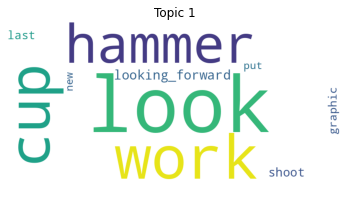

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


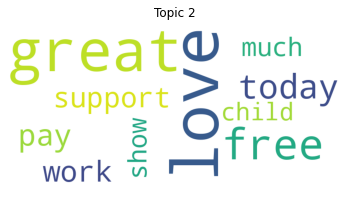

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


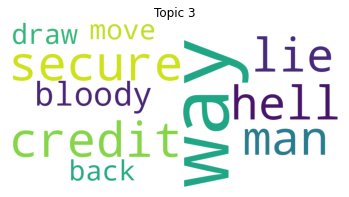

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


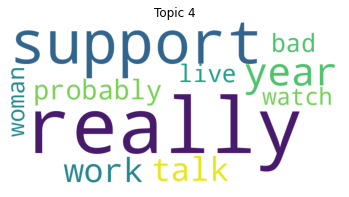

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


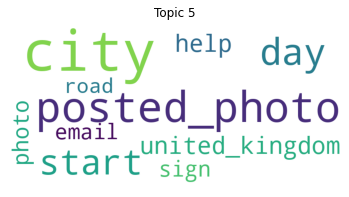

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


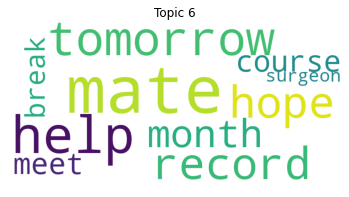

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


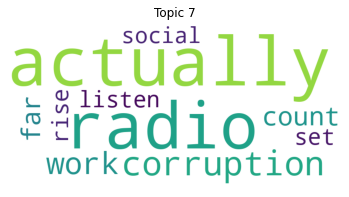

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


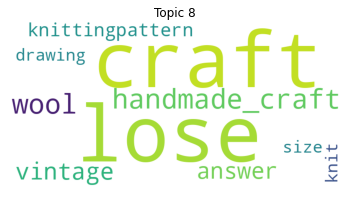

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


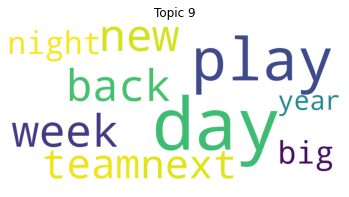

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


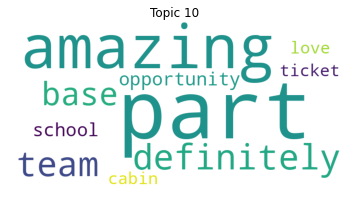

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


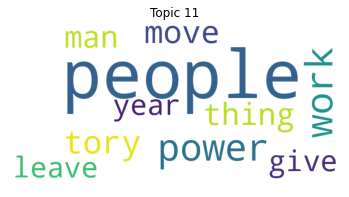

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


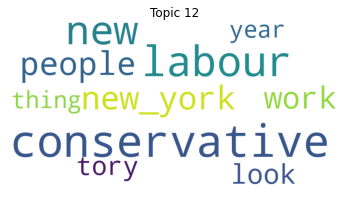

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


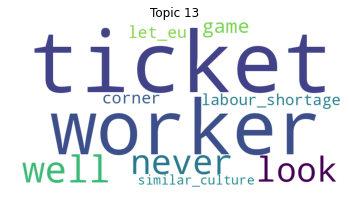

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


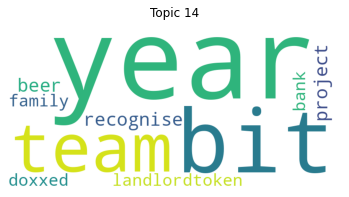

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


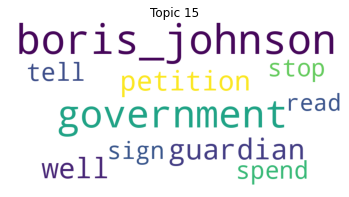

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


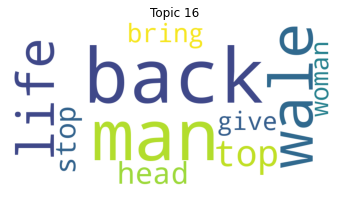

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


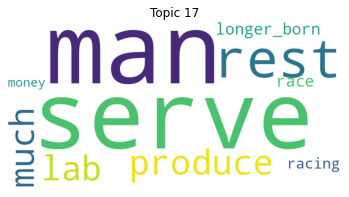

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


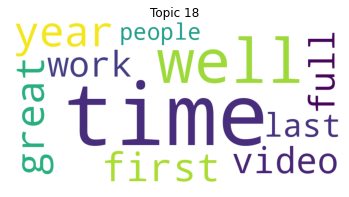

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


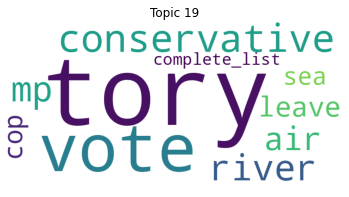

In [167]:
# Group Tweeets Optimal n
# Build LDA model
ogmodel = gensim.models.ldamodel.LdaModel(corpus=gcorpus,
                                          id2word=gid2word,
                                          num_topics=20,
                                          random_state=5000,
      #                                   update_every=1,
      #                                   chunksize=70,
                                          passes=20,
                                          alpha='auto',
                                          per_word_topics=True,
                                          eta='symmetric')

visualize_topics(ogmodel)

In [ ]:
ogcoherence_model = CoherenceModel(model=ogmodel, texts=gdata_ready, dictionary=gid2word, coherence='c_v')
ogcoherence_score = ogcoherence_model.get_coherence()
ogperplexity = ogmodel.log_perplexity(gcorpus)


In [178]:
print("Coherence score of the model is:", ogcoherence_score)
print("Perplexity of the model is:", ogperplexity)

Coherence score of the model is: 0.29049523862320314
Perplexity of the model is: -8.666038498056318


In [170]:
pyLDAvis.enable_notebook()
pg = pyLDAvis.gensim.prepare(ogmodel, gcorpus, gid2word)
pg

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.113201 -0.046976       1        1  24.349923
9      0.122134  0.041767       2        1  15.954185
18     0.114187 -0.005210       3        1   8.864710
13     0.056023  0.190924       4        1   5.643450
17     0.081690 -0.031361       5        1   5.496896
11     0.103374 -0.055675       6        1   5.154743
15     0.074458 -0.035746       7        1   4.671201
4      0.057719  0.014137       8        1   4.643560
2      0.047666  0.040943       9        1   4.094868
0      0.007070 -0.075376      10        1   3.833894
16     0.036749 -0.024239      11        1   3.589334
5     -0.068767  0.100371      12        1   2.632540
19    -0.015748 -0.098767      13        1   2.549485
1     -0.047063  0.027694      14        1   1.908351
6     -0.068037 -0.005937      15        1   1.704565
10    -0.089303  0.026076      16        1   1.602600
14    -0.107420 -0.010934      17        1   1.078429
7     -0.125083 -0.022384      18        1   1.037036
8     -0.150861 -0.021348      19        1   0.692138
3     -0.141991 -0.007959      20        1   0.498092, topic_info=              Term        Freq       Total Category  logprob  loglift
1082        people  293.000000  293.000000  Default  30.0000  30.0000
1291          time  255.000000  255.000000  Default  29.0000  29.0000
1456  conservative  222.000000  222.000000  Default  28.0000  28.0000
612           tory  156.000000  156.000000  Default  27.0000  27.0000
425          great  133.000000  133.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
1352        worker    0.693076   84.148730  Topic20  -5.9607   0.5029
101           home    0.692862   69.435409  Topic20  -5.9610   0.6948
28           bring    0.692599   53.856028  Topic20  -5.9614   0.9485
1209         share    0.691386   46.846137  Topic20  -5.9632   1.0862
1420           ask    0.690474   67.439413  Topic20  -5.9645   0.7205

[1434 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
10563     13  0.694120   absence
642        1  0.114729  absolute
642        3  0.057364  absolute
642        5  0.057364  absolute
642        6  0.114729  absolute
...      ...       ...       ...
1357      13  0.372477      zone
1357      15  0.124159      zone
9932      18  0.806574       𝐡𝐢𝐦
9933      18  0.806574   𝙋𝙡𝙚𝙖𝙙𝙚𝙙
9934      18  0.806574      𝙬𝙞𝙩𝙝

[4894 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 10, 19, 14, 18, 12, 16, 5, 3, 1, 17, 6, 20, 2, 7, 11, 15, 8, 9, 4])

Comparison

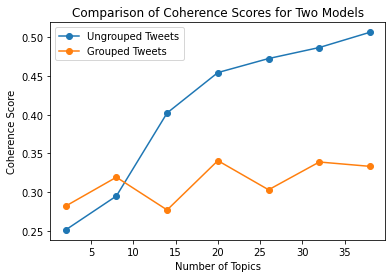

In [200]:
# Comparing coherence
# Data for ungrouped tweets
x = range(2, 40, 6)
y1 = coherence_values

# Data for grouped tweets
y2 = gcoherence_values

# Plotting the graph
plt.plot(x, y1, '-o', label='Ungrouped Tweets')
plt.plot(x, y2, '-o', label='Grouped Tweets')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Comparison of Coherence Scores for Two Models')
plt.legend(loc='best')
plt.show()


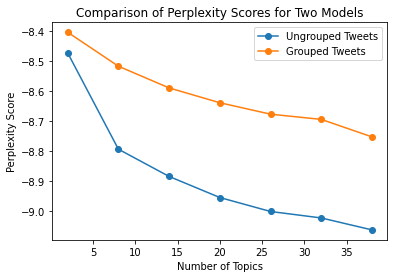

In [201]:
# Comparing Perplexity
# Data for ungrouped tweets
x = range(2, 40, 6)
y1 = perplexity_values

# Data for grouped tweets
y2 = gperplexity_values

# Plotting the graph
plt.plot(x, y1, '-o', label='Ungrouped Tweets')
plt.plot(x, y2, '-o', label='Grouped Tweets')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.title('Comparison of Perplexity Scores for Two Models')
plt.legend(loc='best')
plt.show()


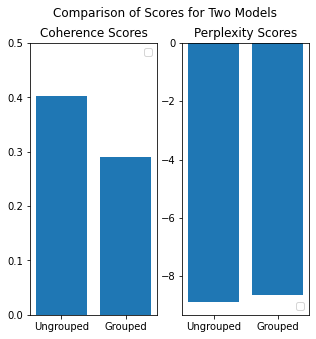

In [202]:
# Comparing performance of optimized model with best n for each
import matplotlib.pyplot as plt

# Final coherence scores for each model
coherence_scores = [ocoherence_score, ogcoherence_score]

# Final perplexity scores for each model
perplexity_scores = [operplexity, ogperplexity]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 5))

# Plot the coherence scores on the first subplot
ax1.bar(range(len(coherence_scores)), coherence_scores, tick_label=['Ungrouped', 'Grouped'])
ax1.set_title('Coherence Scores')
ax1.set_ylim([0, 0.5])

# Plot the perplexity scores on the second subplot
ax2.bar(range(len(perplexity_scores)), perplexity_scores, tick_label=['Ungrouped', 'Grouped'])
ax2.set_title('Perplexity Scores')

# Add legends to each subplot
ax1.legend()
ax2.legend()

# Add a title for the entire figure
fig.suptitle('Comparison of Scores for Two Models')

# Show the plot
plt.show()


In [207]:
# Document Topic Distribution for ungrouped tweets
# Get topic distribution for each document
for i in range(len(corpus)):
    doc_topics, word_topics, phi_values = omodel.get_document_topics(corpus[i], per_word_topics=True)
    print(f"Document {i+1}:")
    print(f"Topic Distribution: {doc_topics}")
    if len(doc_topics) > 0:
        max_topic, max_prob = max(doc_topics, key=lambda x:x[1])
        print(f"Main Topic: {max_topic}, Probability: {max_prob}")
    print("------------------------")



Streaming output truncated to the last 5000 lines.
Document 6128:
Topic Distribution: [(4, 0.09425375), (6, 0.5201825), (12, 0.31891426)]
Main Topic: 6, Probability: 0.5201824903488159
------------------------
Document 6129:
Topic Distribution: [(1, 0.06078712), (2, 0.4347995), (5, 0.3106755), (8, 0.13947192)]
Main Topic: 2, Probability: 0.4347994923591614
------------------------
Document 6130:
Topic Distribution: [(0, 0.26394334), (2, 0.46419102), (8, 0.07590366), (12, 0.13704601)]
Main Topic: 2, Probability: 0.4641910195350647
------------------------
Document 6131:
Topic Distribution: [(0, 0.13514562), (1, 0.13179761), (2, 0.010668399), (4, 0.01261495), (5, 0.010491738), (7, 0.6022996), (8, 0.010039884), (9, 0.017186368), (10, 0.011965158), (11, 0.01141209), (12, 0.016865699), (13, 0.010180177)]
Main Topic: 7, Probability: 0.6022995710372925
------------------------
Document 6132:
Topic Distribution: [(0, 0.011612976), (1, 0.014905179), (2, 0.014029276), (3, 0.012523963), (4, 0.244

In [208]:
# Get the topic distribution for each document in the corpus
doc_topics = omodel.get_document_topics(corpus)

# Define thresholds for appropriate and not so good topic distribution
good_topic_threshold = 0.5  # topic weight above this value is considered good
bad_topic_threshold = 0.2   # topic weight below this value is considered not so good

# Create lists to hold the documents with good and not so good topic distribution
good_topic_docs = []
bad_topic_docs = []

# Loop through each document and check its topic distribution
for i, topics in enumerate(doc_topics):
    # Sort the topics by their weight in descending order
    sorted_topics = sorted(topics, key=lambda x: x[1], reverse=True)
    
    # If the top topic has a weight above the good_topic_threshold, consider it a good topic distribution
    if sorted_topics[0][1] >= good_topic_threshold:
        good_topic_docs.append(i)
    # If the top topic has a weight below the bad_topic_threshold, consider it a not so good topic distribution
    elif sorted_topics[0][1] <= bad_topic_threshold:
        bad_topic_docs.append(i)
        
# Print the number of documents with good and not so good topic distribution
print(f"Number of documents with good topic distribution: {len(good_topic_docs)}")
print(f"Number of documents with not so good topic distribution: {len(bad_topic_docs)}")


Number of documents with good topic distribution: 3614
Number of documents with not so good topic distribution: 201


In [209]:
# Document Topic Distribution for grouped tweets
# Get topic distribution for each document
for i in range(len(gcorpus)):
    doc_topics, word_topics, phi_values = ogmodel.get_document_topics(gcorpus[i], per_word_topics=True)
    print(f"Document {i+1}:")
    print(f"Topic Distribution: {doc_topics}")
    if len(doc_topics) > 0:
        max_topic, max_prob = max(doc_topics, key=lambda x:x[1])
        print(f"Main Topic: {max_topic}, Probability: {max_prob}")
    print("------------------------")



Document 1:
Topic Distribution: [(13, 0.998088)]
Main Topic: 13, Probability: 0.998088002204895
------------------------
Document 2:
Topic Distribution: [(18, 0.9958606)]
Main Topic: 18, Probability: 0.9958605766296387
------------------------
Document 3:
Topic Distribution: [(2, 0.9990162)]
Main Topic: 2, Probability: 0.9990162253379822
------------------------
Document 4:
Topic Distribution: [(9, 0.22923787), (12, 0.7031592), (13, 0.02405218), (18, 0.016647663)]
Main Topic: 12, Probability: 0.7031592130661011
------------------------
Document 5:
Topic Distribution: [(13, 0.9978711)]
Main Topic: 13, Probability: 0.9978711009025574
------------------------
Document 6:
Topic Distribution: [(1, 0.017548913), (9, 0.01022435), (13, 0.028557863), (15, 0.013490699), (17, 0.92965806)]
Main Topic: 17, Probability: 0.929658055305481
------------------------
Document 7:
Topic Distribution: [(0, 0.9958812)]
Main Topic: 0, Probability: 0.995881199836731
------------------------
Document 8:
Topic D

In [210]:
# Get the topic distribution for each document in the corpus
doc_topics = ogmodel.get_document_topics(gcorpus)

# Define thresholds for appropriate and not so good topic distribution
good_topic_threshold = 0.5  # topic weight above this value is considered good
bad_topic_threshold = 0.2   # topic weight below this value is considered not so good

# Create lists to hold the documents with good and not so good topic distribution
good_topic_docs = []
bad_topic_docs = []

# Loop through each document and check its topic distribution
for i, topics in enumerate(doc_topics):
    # Sort the topics by their weight in descending order
    sorted_topics = sorted(topics, key=lambda x: x[1], reverse=True)
    
    # If the top topic has a weight above the good_topic_threshold, consider it a good topic distribution
    if sorted_topics[0][1] >= good_topic_threshold:
        good_topic_docs.append(i)
    # If the top topic has a weight below the bad_topic_threshold, consider it a not so good topic distribution
    elif sorted_topics[0][1] <= bad_topic_threshold:
        bad_topic_docs.append(i)
        
# Print the number of documents with good and not so good topic distribution
print(f"Number of documents with good topic distribution: {len(good_topic_docs)}")
print(f"Number of documents with not so good topic distribution: {len(bad_topic_docs)}")


Number of documents with good topic distribution: 428
Number of documents with not so good topic distribution: 16
